# Импорт библиотек

In [403]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.6f}'.format) # Отключу научную нотацию
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import pingouin as pg
import optuna

import warnings
warnings.filterwarnings('ignore')

# Выгрузка данных

In [404]:
data = pd.read_csv('data.csv')
data.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,...,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,AnnualBonus
0,41,Yes,Travel_Rarely,1,2,Female,3,Sales Executive,4,Single,...,19479,8,11,3,1,8,6,4,0,141
1,49,No,Travel_Frequently,8,1,Male,2,Research Scientist,2,Married,...,24907,1,23,4,4,10,10,7,1,161
2,37,Yes,Travel_Rarely,2,2,Male,2,Laboratory Technician,3,Single,...,2396,6,15,3,2,7,0,0,0,33
3,33,No,Travel_Frequently,3,4,Female,3,Research Scientist,3,Married,...,23159,1,11,3,3,8,8,7,3,92
4,27,No,Travel_Rarely,2,1,Male,3,Laboratory Technician,2,Married,...,16632,9,12,3,4,6,2,2,2,81


In [405]:
N, K = data.shape

print(f'''
N (число наблюдений) = {N}
K (число признаков) = {K}
''')


N (число наблюдений) = 1470
K (число признаков) = 21



# Описание признаков

In [406]:
data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education',
       'Gender', 'JobInvolvement', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'AnnualBonus'],
      dtype='object')

In [407]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DistanceFromHome          1470 non-null   int64 
 4   Education                 1470 non-null   int64 
 5   Gender                    1470 non-null   object
 6   JobInvolvement            1470 non-null   int64 
 7   JobRole                   1470 non-null   object
 8   JobSatisfaction           1470 non-null   int64 
 9   MaritalStatus             1470 non-null   object
 10  MonthlyIncome             1470 non-null   int64 
 11  MonthlyRate               1470 non-null   int64 
 12  NumCompaniesWorked        1470 non-null   int64 
 13  PercentSalaryHike         1470 non-null   int64 
 14  PerformanceRating       

__Разбиение на количественные и категориальные признаки:__

In [408]:
num_var = [
    'Age',
    'DistanceFromHome',
    'MonthlyIncome',
    'MonthlyRate',
    'NumCompaniesWorked',
    'PercentSalaryHike',
    'TotalWorkingYears',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsSinceLastPromotion',
    'AnnualBonus'
]

categorical_var = list(set(data.columns) - set(num_var))

## Обработка пропусков

In [409]:
data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DistanceFromHome            0
Education                   0
Gender                      0
JobInvolvement              0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
TotalWorkingYears           0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
AnnualBonus                 0
dtype: int64

__Вывод:__

- Данные не имеют пропусков

## Первичный анализ

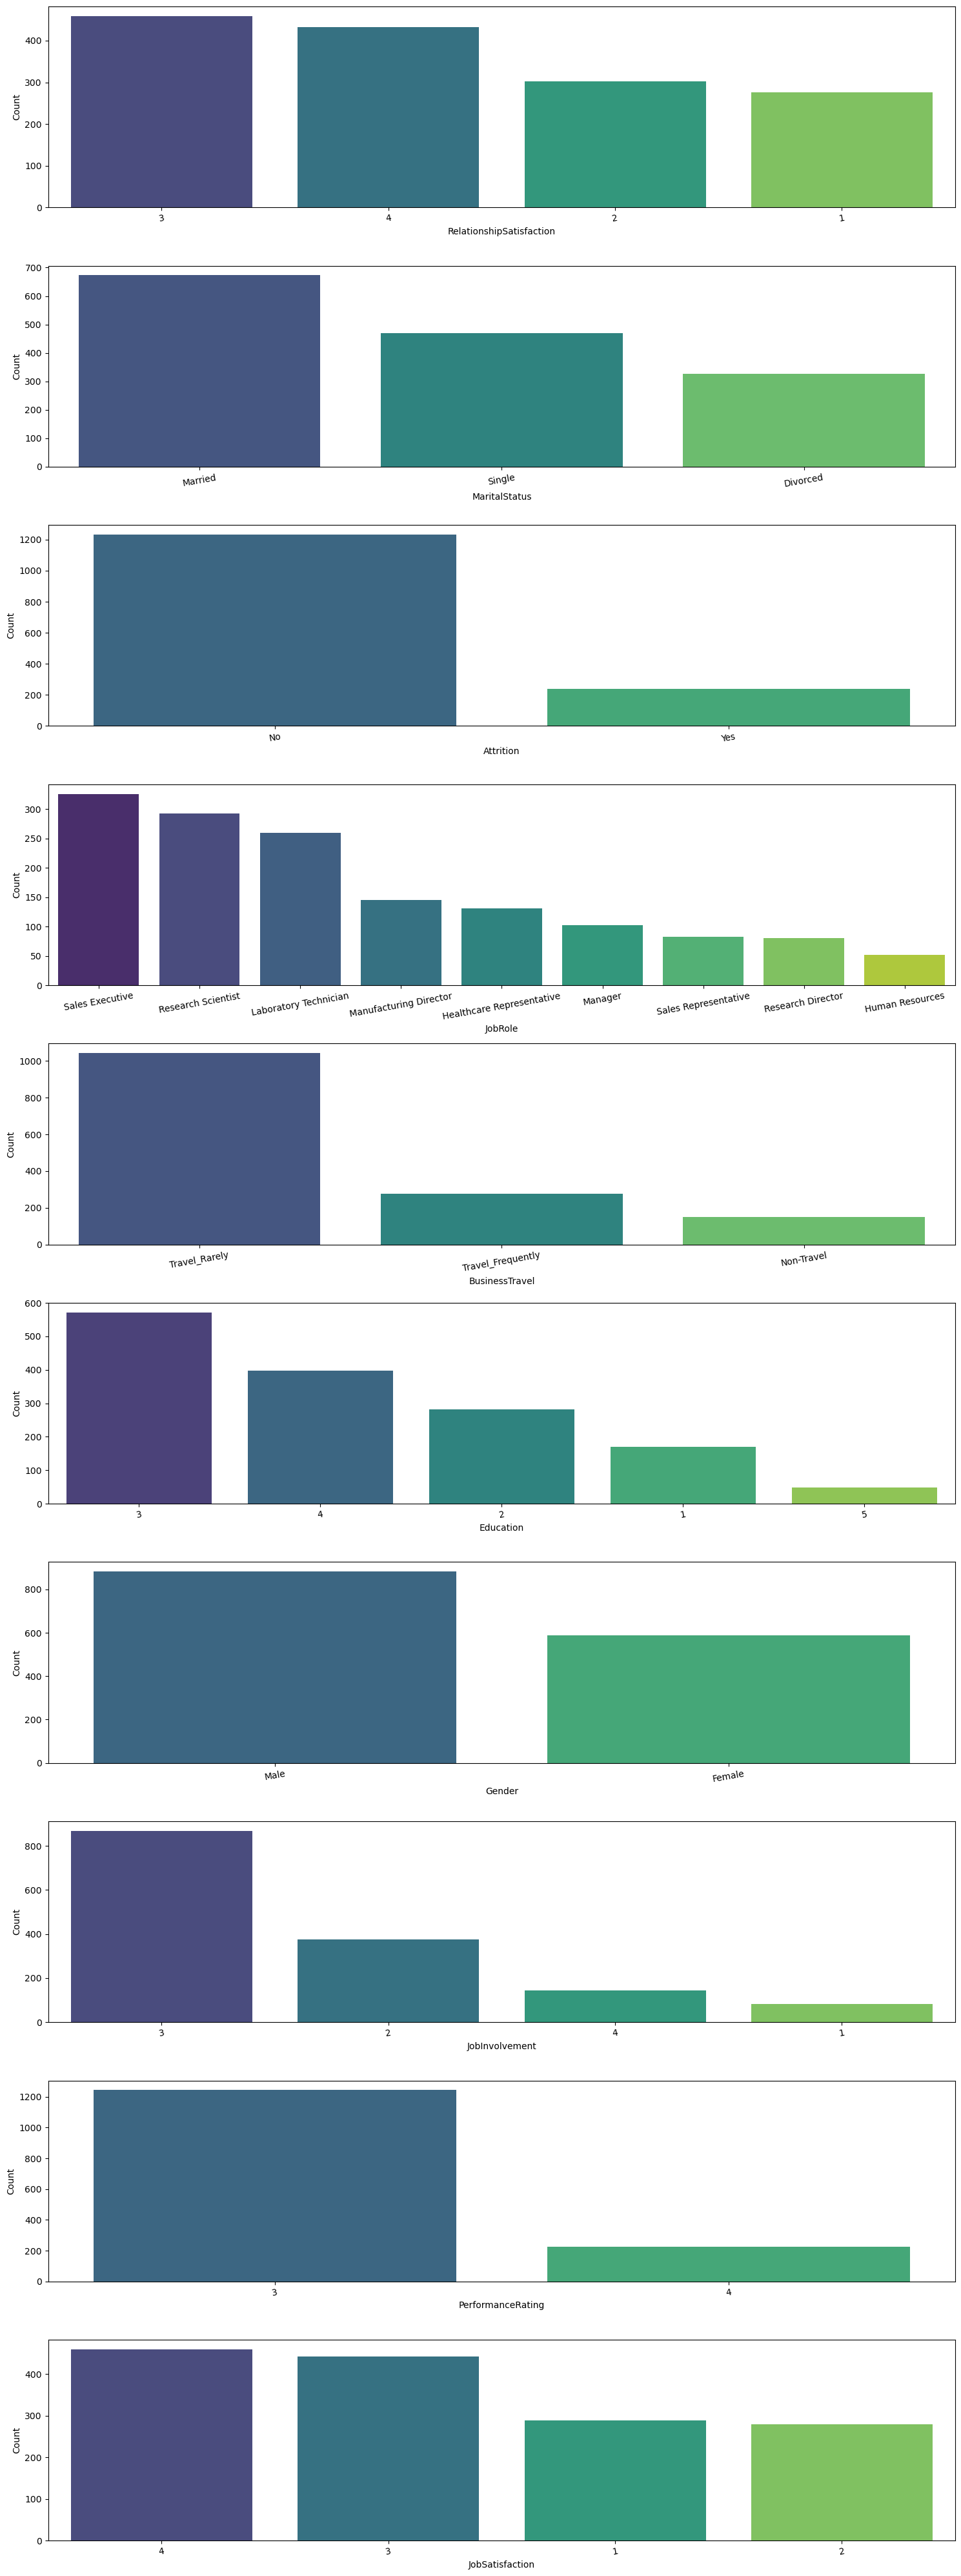

In [410]:
fig, ax = plt.subplots(len(categorical_var), figsize=(15, 40))

for i, column in enumerate(categorical_var):
    value_counts = data[column].value_counts()
    sns.barplot(
        x=value_counts.index.astype(str), 
        y=value_counts.values, 
        ax=ax[i], 
        palette="viridis"
    )
    ax[i].set_xticklabels(value_counts.index.astype(str), rotation=10)
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Count')
plt.tight_layout()

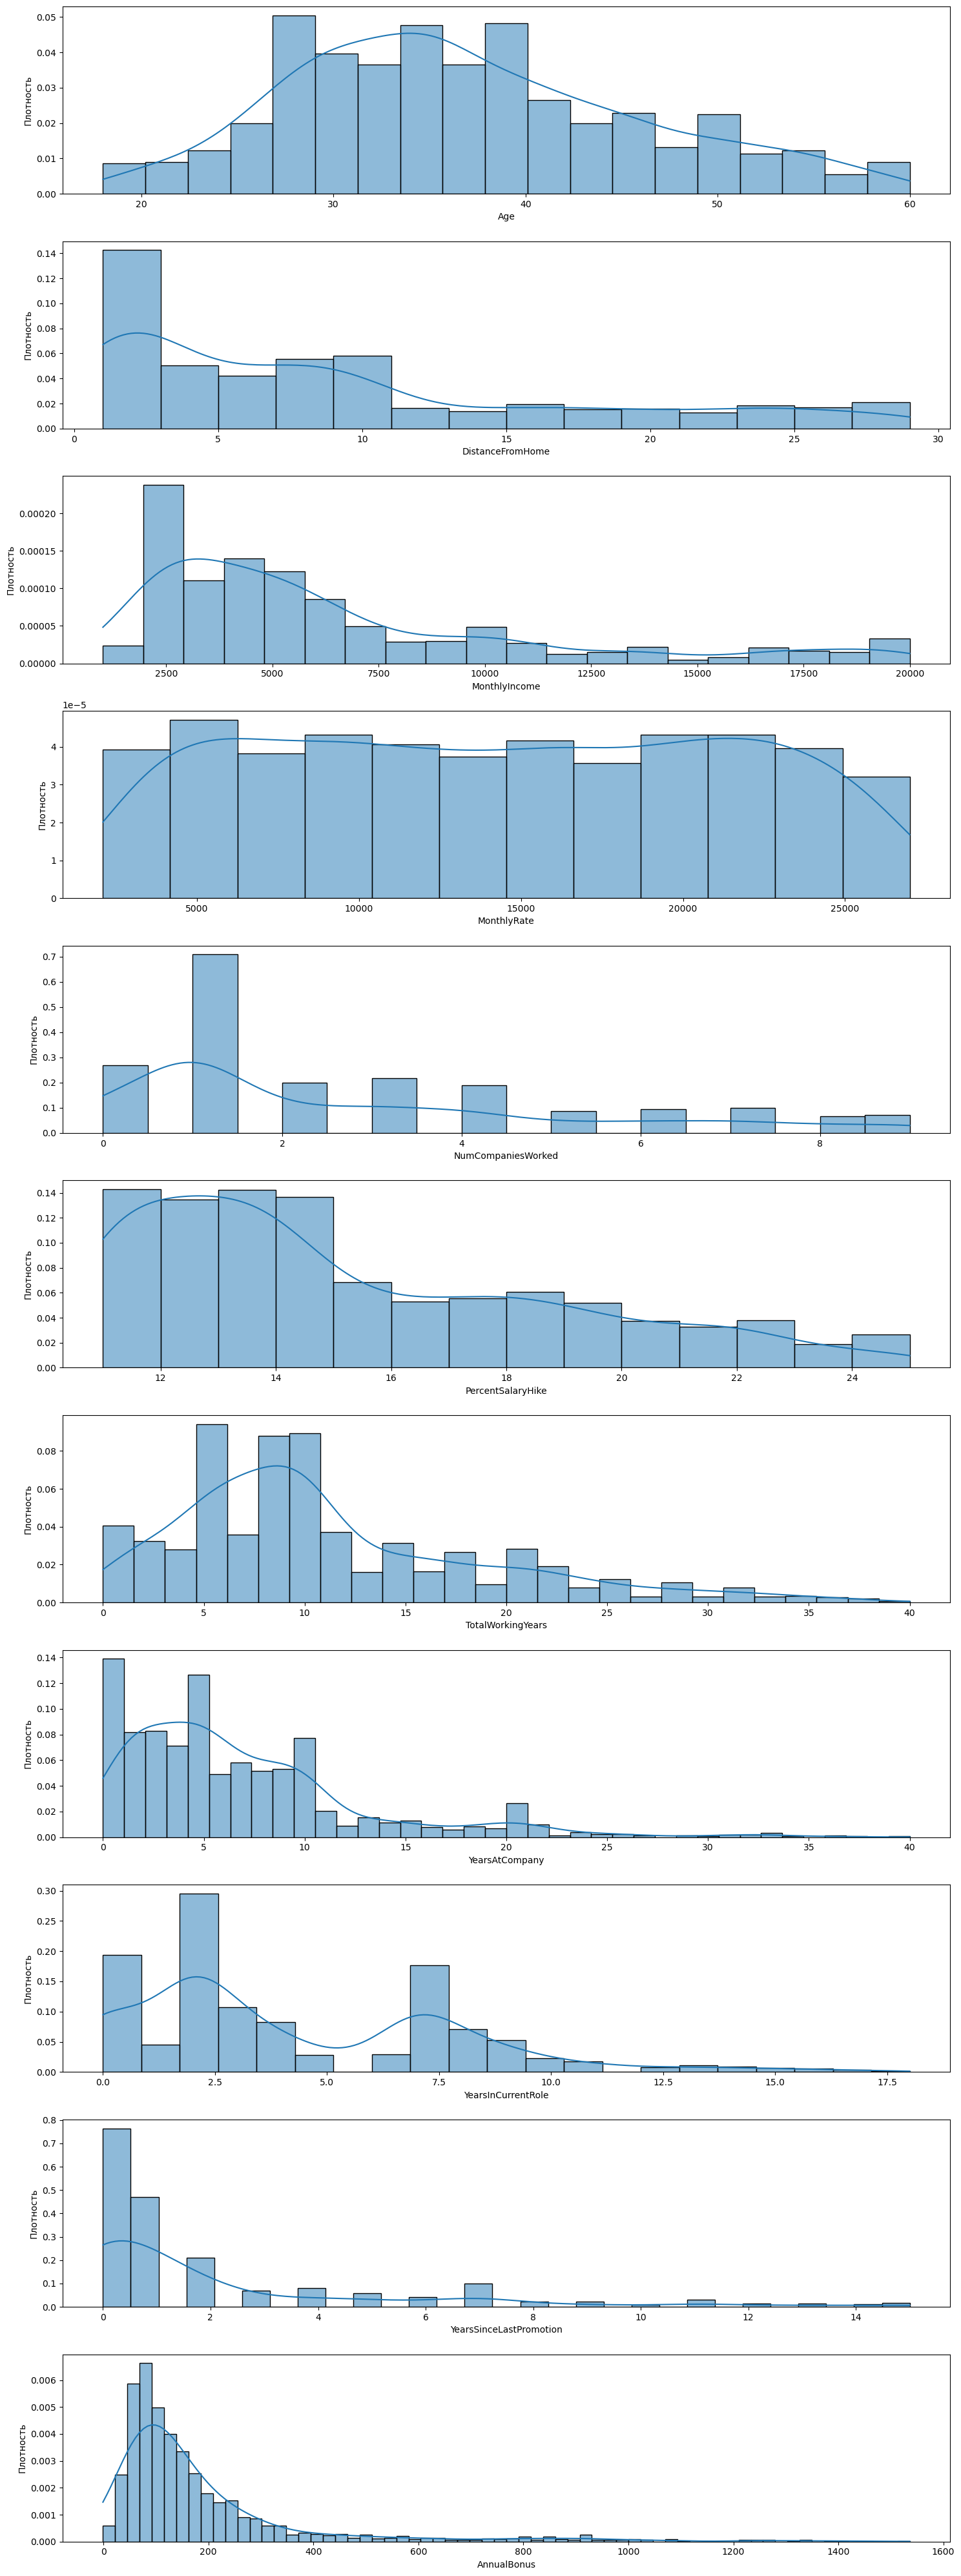

In [411]:
fig, ax = plt.subplots(len(num_var), figsize=(15, 40))

for i, column in enumerate(num_var):
    sns.histplot(
        x=data[column],
        ax=ax[i], 
        kde=True,
        stat='density'
    )
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Плотность')
plt.tight_layout()

__Вывод:__

- Данные распределены в большинстве своём *ненормально*

- Переменная, которая может иметь нормальное распределение - возраст сотрудника. Необходимо будет проверить это 

__Описательные статистики для количественных и качественных признаков:__

In [412]:
data[num_var].describe()

,Age,DistanceFromHome,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,AnnualBonus
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,9.192517,6502.931293,14313.103401,2.693197,15.209524,11.279592,7.008163,4.229252,2.187755,189.231293
std,9.135373,8.106864,4707.956783,7117.786044,2.498009,3.659938,7.780782,6.126525,3.623137,3.222430,211.262720
min,18.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,30.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,6.000000,3.000000,2.000000,0.000000,75.000000
50%,36.000000,7.000000,4919.000000,14235.500000,2.000000,14.000000,10.000000,5.000000,3.000000,1.000000,120.000000
75%,43.000000,14.000000,8379.000000,20461.500000,4.000000,18.000000,15.000000,9.000000,7.000000,3.000000,208.000000
max,60.000000,29.000000,19999.000000,26999.000000,9.000000,25.000000,40.000000,40.000000,18.000000,15.000000,1536.000000


In [413]:
data[categorical_var].describe(include=[object])

,MaritalStatus,Attrition,JobRole,BusinessTravel,Gender
count,1470,1470,1470,1470,1470
unique,3,2,9,3,2
top,Married,No,Sales Executive,Travel_Rarely,Male
freq,673,1233,326,1043,882


## Анализ зависимости переменных 

In [414]:
# plt.figure(figsize=(12, 10))
# sns.pairplot(
#     data=data[num_var],
#     diag_kind="kde", 
#     kind="reg",  
#     palette="coolwarm",
#     plot_kws={
#         'scatter_kws': {'alpha': 0.9, 's': 30, 'edgecolor': None}, 
#         'line_kws': {'color': 'red'}
#         }
# )

Text(0.5, 1.0, 'Тепловая карта корреляционной матрицы числовых переменных')

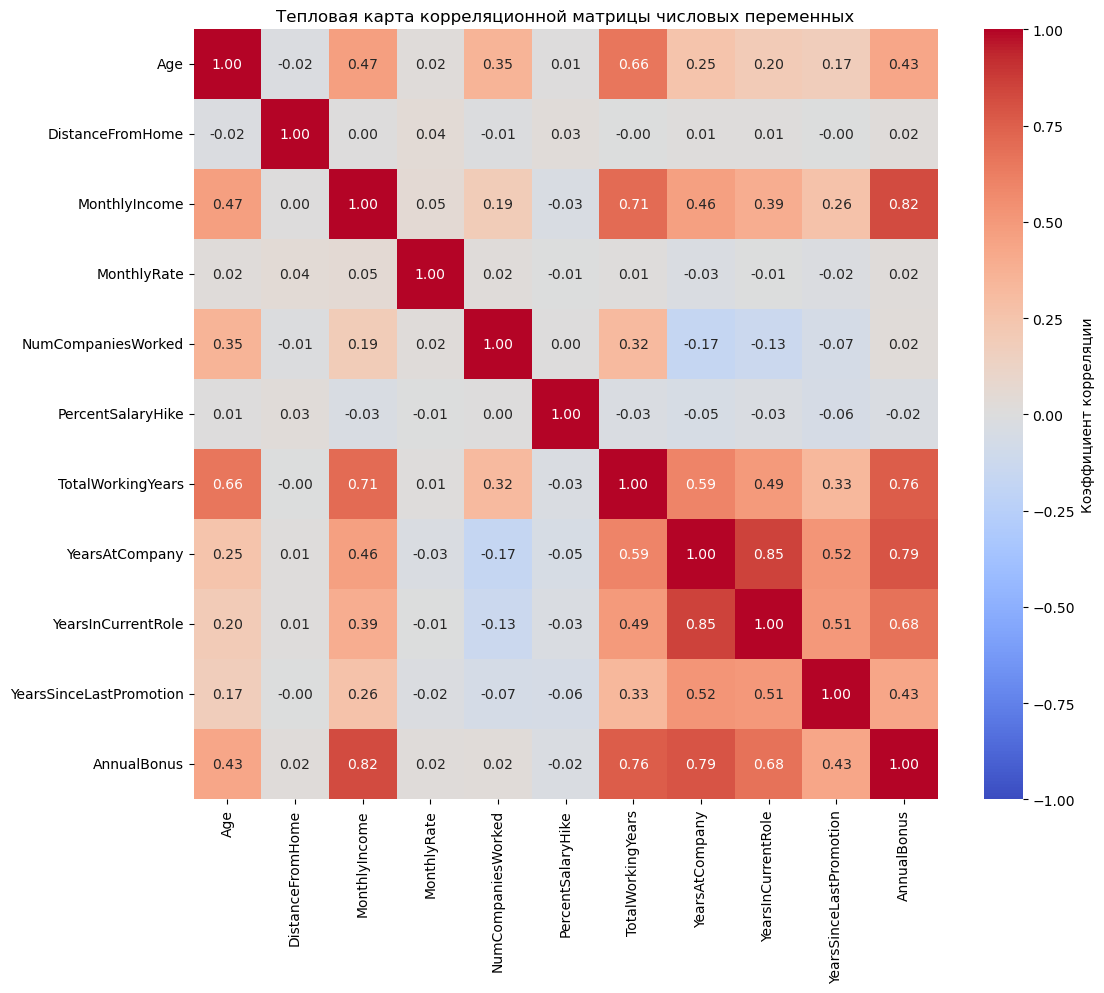

In [415]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    data=data[num_var].corr(method='spearman'), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    cbar_kws={'label': 'Коэффициент корреляции'}
)

plt.title('Тепловая карта корреляционной матрицы числовых переменных')

## Диагностика и обработка выбросов

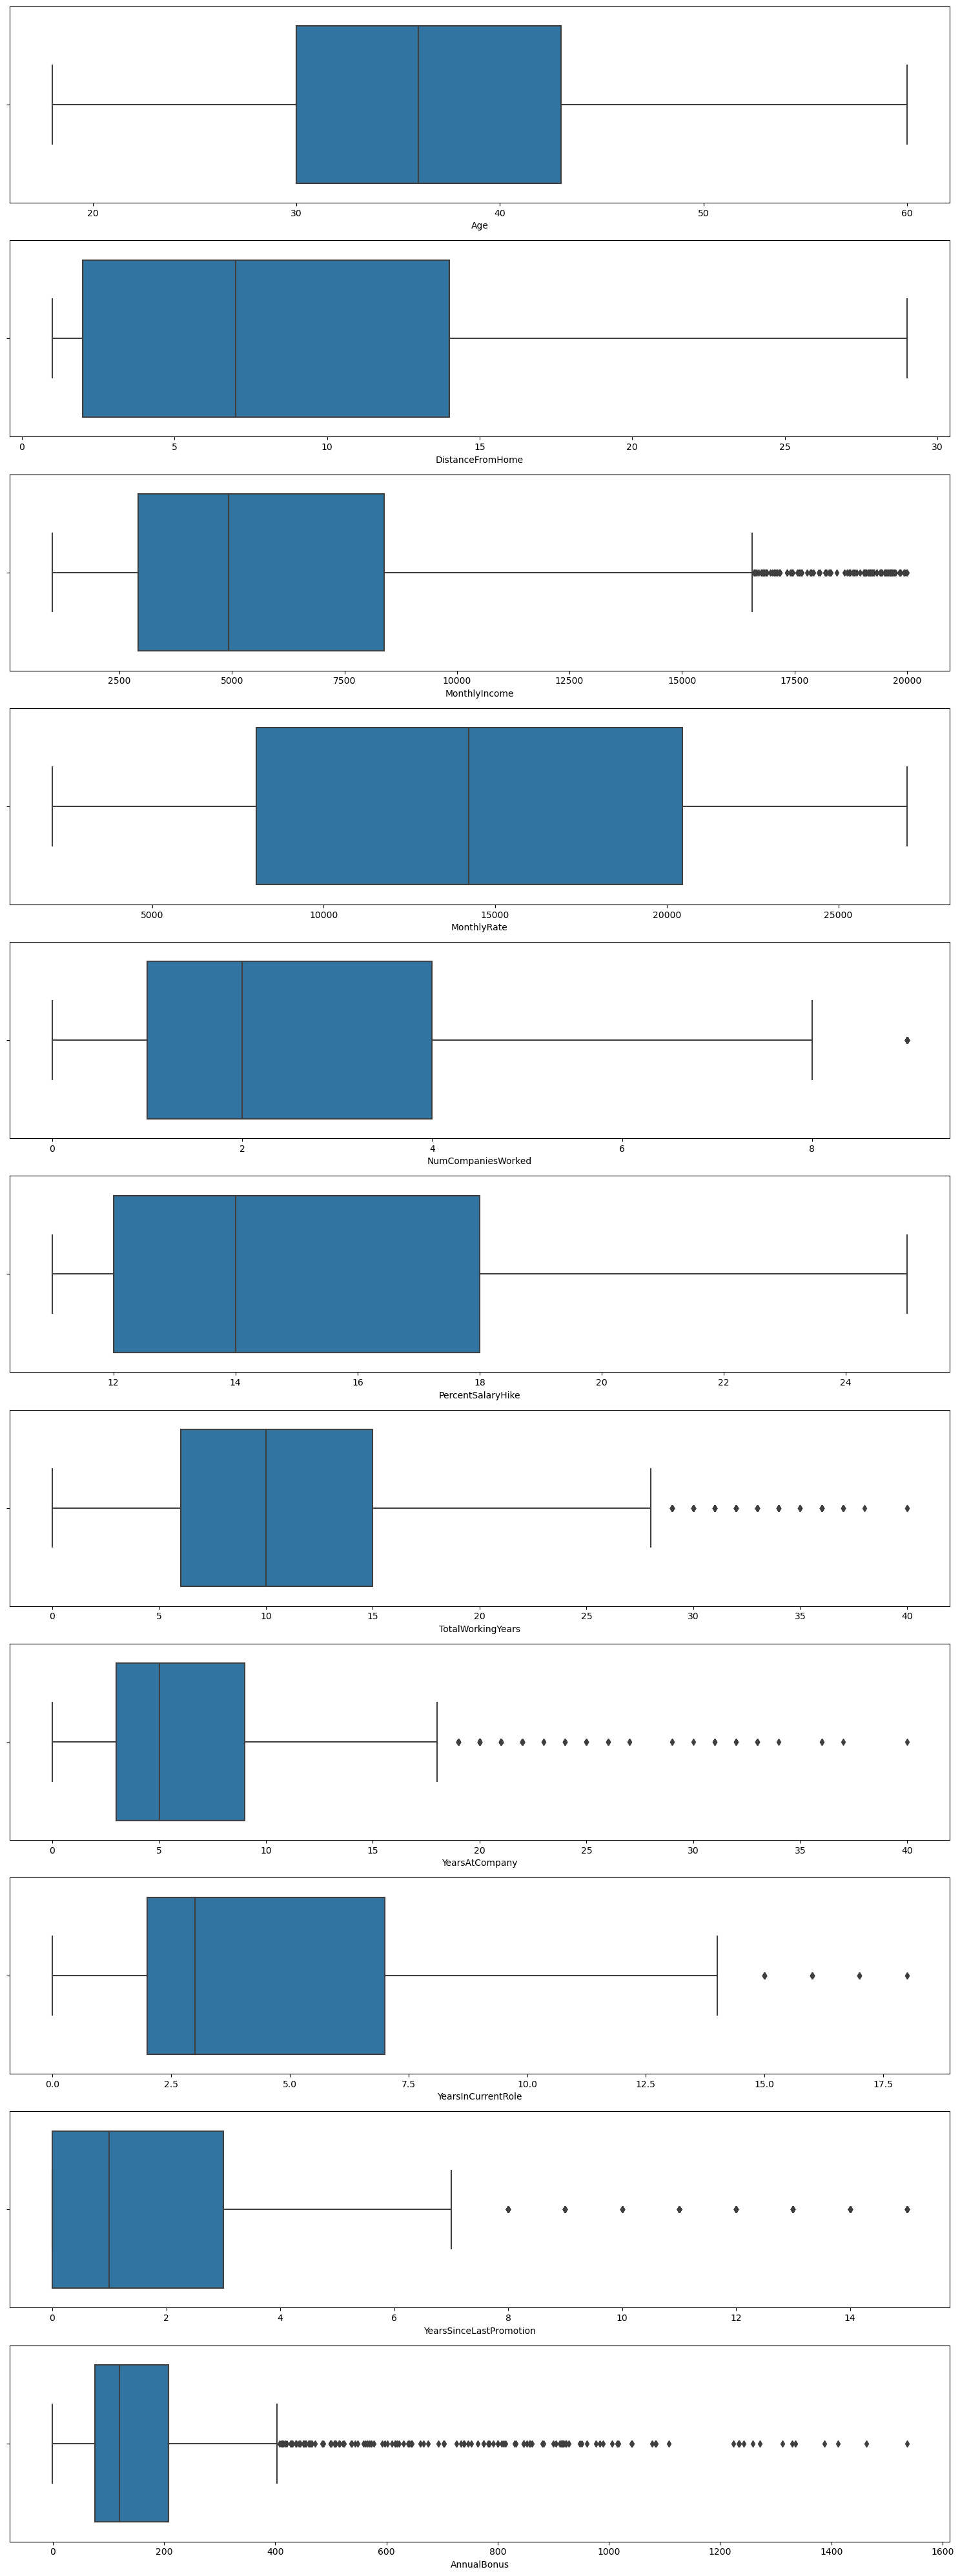

In [416]:
fig, ax = plt.subplots(len(num_var), figsize=(15, 40))

for i, column in enumerate(num_var):
    sns.boxplot(
        x=data[column],
        ax=ax[i]
    )
    ax[i].set_xlabel(column)
plt.tight_layout()

__Вывод:__

- Видны выбросы почти для каждой количественной переменной. Прийдётся обработать данные перед тем, как строить линейные модели

## Энкодинг оставшихся категориальных переменных

In [417]:
from sklearn.preprocessing import LabelEncoder

# Label-encoding
le = LabelEncoder()
for i in ['Attrition', 'Gender']:
    data[i] = le.fit_transform(data[i])

# One-hot-encoding
data = pd.get_dummies(
    data, columns=['BusinessTravel', 'JobRole', 'MaritalStatus']
)

# Классификация

Задача:
- Предсказать, уволится ли человек с работы

In [418]:
y, X = data.Attrition, data.drop(['Attrition', 'AnnualBonus'], axis=1)

In [419]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Так как для классификации будут использоваться композиции деревьев, поэтому масштабировать признаки не является обязательным

In [420]:
y.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

Мы видим, что один класс значительно больше другого. Использовать accuracy для оценки результатов некорректно

## Случайный лес

Обучу гиперпараметры через специализированную библиотеку optuna

Буду максимизировать метрику f-beta с перевесом важности полноты

In [421]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, confusion_matrix, precision_recall_curve, roc_curve, average_precision_score, roc_auc_score, precision_score, recall_score, fbeta_score, f1_score

sampler = optuna.samplers.TPESampler()

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 2, 150) # Число деревьев
    max_depth = trial.suggest_int('max_depth', 1, 32) # Максимальная глубина дерева
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=42
    )

    return np.mean(
        cross_val_score(
            clf, X_train, y_train, 
            n_jobs=-1, 
            scoring=make_scorer(fbeta_score, beta=1.5), 
            cv=StratifiedKFold(n_splits=3)))

study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_params

[I 2023-12-03 14:57:45,815] A new study created in memory with name: no-name-ed5ab665-be6d-4e40-a037-e272bbd4a803
[I 2023-12-03 14:57:51,858] Trial 0 finished with value: 0.22627283148068433 and parameters: {'n_estimators': 69, 'max_depth': 26}. Best is trial 0 with value: 0.22627283148068433.
[I 2023-12-03 14:57:54,098] Trial 1 finished with value: 0.2202194003361743 and parameters: {'n_estimators': 137, 'max_depth': 30}. Best is trial 0 with value: 0.22627283148068433.
[I 2023-12-03 14:57:54,568] Trial 2 finished with value: 0.2202194003361743 and parameters: {'n_estimators': 141, 'max_depth': 24}. Best is trial 0 with value: 0.22627283148068433.
[I 2023-12-03 14:57:54,699] Trial 3 finished with value: 0.2309664332527951 and parameters: {'n_estimators': 35, 'max_depth': 31}. Best is trial 3 with value: 0.2309664332527951.
[I 2023-12-03 14:57:55,152] Trial 4 finished with value: 0.20660102531420188 and parameters: {'n_estimators': 146, 'max_depth': 9}. Best is trial 3 with value: 0.23

{'n_estimators': 13, 'max_depth': 19}

In [422]:
clf = RandomForestClassifier(**best_params)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

confusion_matrix(y_test, y_pred)

array([[313,   7],
       [ 44,   4]], dtype=int64)

In [423]:
# Метрики:
print(f'''
AUC-PR = {average_precision_score(y_test, y_pred)}, 
AUC-ROC = {roc_auc_score(y_test, y_pred)}, 
precision = {precision_score(y_test, y_pred)}, 
recall = {recall_score(y_test, y_pred)}, 
f1 = {f1_score(y_test, y_pred)}
      ''') 


AUC-PR = 0.14986824769433466, 
AUC-ROC = 0.5307291666666666, 
precision = 0.36363636363636365, 
recall = 0.08333333333333333, 
f1 = 0.13559322033898305
      


Text(0.5, 1.0, 'ROC Curve')

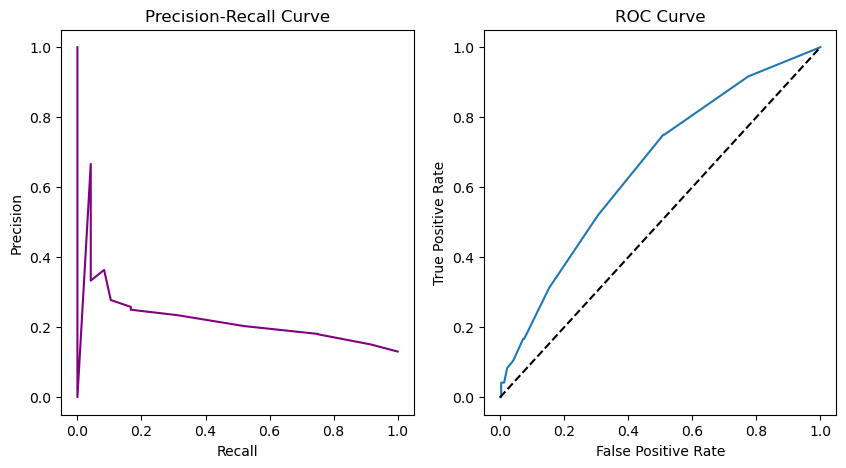

In [424]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(recall, precision, color='purple')
ax[0].set_title('Precision-Recall Curve')
ax[0].set_ylabel('Precision')
ax[0].set_xlabel('Recall')

ax[1].plot(fpr, tpr)
ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')

## Градиентный бустинг

In [425]:
from catboost import CatBoostClassifier

def objective(trial):

    cbc = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )

    return np.mean(
        cross_val_score(
            cbc, X_train, y_train, 
            n_jobs=-1, scoring=make_scorer(fbeta_score, beta=1.5), 
            cv=StratifiedKFold(n_splits=3)))

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params

[I 2023-12-03 14:58:08,670] A new study created in memory with name: no-name-9299822a-448d-4365-a730-71457d7fb586
[I 2023-12-03 14:58:15,148] Trial 0 finished with value: 0.20291849848948826 and parameters: {'iterations': 665, 'learning_rate': 0.00689784667240147, 'depth': 8, 'l2_leaf_reg': 0.0009918207865700348, 'bootstrap_type': 'Bayesian', 'random_strength': 2.759667141536931e-08, 'bagging_temperature': 5.981821648749835, 'od_type': 'Iter', 'od_wait': 22}. Best is trial 0 with value: 0.20291849848948826.
[I 2023-12-03 14:58:20,512] Trial 1 finished with value: 0.18831900804203835 and parameters: {'iterations': 336, 'learning_rate': 0.0030133240007065433, 'depth': 9, 'l2_leaf_reg': 4.749272193647878e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.005304728421639667, 'bagging_temperature': 0.8963388730254351, 'od_type': 'IncToDec', 'od_wait': 20}. Best is trial 0 with value: 0.20291849848948826.
[I 2023-12-03 14:58:22,349] Trial 2 finished with value: 0.1625789543082912 and pa

In [426]:
cbc = CatBoostClassifier(**best_params)
cbc.fit(X_train, y_train)

y_pred = cbc.predict(X_test)
y_pred_proba = cbc.predict_proba(X_test)[:, 1]

confusion_matrix(y_test, y_pred)

0:	learn: 0.6520437	total: 140ms	remaining: 2m 18s
1:	learn: 0.6064283	total: 142ms	remaining: 1m 10s
2:	learn: 0.5754417	total: 143ms	remaining: 47.1s
3:	learn: 0.5477790	total: 144ms	remaining: 35.6s
4:	learn: 0.5246889	total: 146ms	remaining: 28.7s
5:	learn: 0.5010326	total: 147ms	remaining: 24.2s
6:	learn: 0.4818673	total: 148ms	remaining: 20.9s
7:	learn: 0.4662516	total: 149ms	remaining: 18.4s
8:	learn: 0.4533851	total: 151ms	remaining: 16.5s
9:	learn: 0.4425201	total: 152ms	remaining: 14.9s
10:	learn: 0.4362286	total: 153ms	remaining: 13.7s
11:	learn: 0.4295321	total: 154ms	remaining: 12.6s
12:	learn: 0.4243422	total: 155ms	remaining: 11.7s
13:	learn: 0.4199240	total: 157ms	remaining: 10.9s
14:	learn: 0.4150428	total: 158ms	remaining: 10.3s
15:	learn: 0.4113051	total: 159ms	remaining: 9.7s
16:	learn: 0.4080623	total: 160ms	remaining: 9.19s
17:	learn: 0.4054831	total: 162ms	remaining: 8.74s
18:	learn: 0.4018056	total: 163ms	remaining: 8.34s
19:	learn: 0.3979327	total: 164ms	remain

array([[307,  13],
       [ 41,   7]], dtype=int64)

In [427]:
# Метрики:
print(f'''
AUC-PR = {average_precision_score(y_test, y_pred)}, 
AUC-ROC = {roc_auc_score(y_test, y_pred)}, 
precision = {precision_score(y_test, y_pred)}, 
recall = {recall_score(y_test, y_pred)}, 
f1 = {f1_score(y_test, y_pred)}
      ''') 


AUC-PR = 0.16245471014492752, 
AUC-ROC = 0.5526041666666666, 
precision = 0.35, 
recall = 0.14583333333333334, 
f1 = 0.20588235294117646
      


Text(0.5, 1.0, 'ROC Curve')

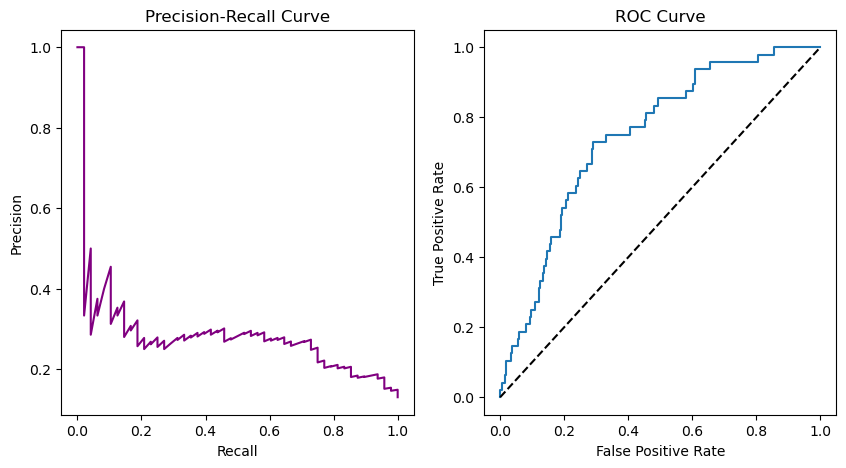

In [428]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(recall, precision, color='purple')
ax[0].set_title('Precision-Recall Curve')
ax[0].set_ylabel('Precision')
ax[0].set_xlabel('Recall')

ax[1].plot(fpr, tpr)
ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')

In [429]:
from xgboost import XGBClassifier

def objective(trial):

    xgb = XGBClassifier(
        max_depth = trial.suggest_int('max_depth', 1, 9),
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        n_estimators = trial.suggest_int('n_estimators', 50, 500),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0),
        subsample = trial.suggest_loguniform('subsample', 0.01, 1.0),
        colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        eval_metric = 'mlogloss',
        use_label_encoder = False
    )

    return np.mean(
        cross_val_score(
            xgb, X_train, y_train, 
            n_jobs=-1, scoring=make_scorer(fbeta_score, beta=1.5), 
            cv=StratifiedKFold(n_splits=3)))

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200)

best_params = study.best_params

[I 2023-12-03 15:00:55,939] A new study created in memory with name: no-name-72a0ae87-c8b7-430d-8125-d5c22d2d66c1


[I 2023-12-03 15:00:56,188] Trial 0 finished with value: 0.25120697306957496 and parameters: {'max_depth': 3, 'learning_rate': 0.10180922167121852, 'n_estimators': 342, 'min_child_weight': 1, 'gamma': 0.05538296979768448, 'subsample': 0.6304845572554403, 'colsample_bytree': 0.016639834177796617, 'reg_alpha': 0.029625635974637663, 'reg_lambda': 2.4480312646658264e-06}. Best is trial 0 with value: 0.25120697306957496.
[I 2023-12-03 15:00:56,257] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 2, 'learning_rate': 0.05638384422971172, 'n_estimators': 95, 'min_child_weight': 5, 'gamma': 2.6987793465594353e-07, 'subsample': 0.04820306081236408, 'colsample_bytree': 0.11521299267909402, 'reg_alpha': 3.673137127449695e-05, 'reg_lambda': 5.240792689011528e-05}. Best is trial 0 with value: 0.25120697306957496.
[I 2023-12-03 15:00:56,424] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 2, 'learning_rate': 0.06473829659936166, 'n_estimators': 404, 'min_child_weight': 1

In [430]:
xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

confusion_matrix(y_test, y_pred)

array([[282,  38],
       [ 34,  14]], dtype=int64)

In [431]:
# Метрики:
print(f'''
AUC-PR = {average_precision_score(y_test, y_pred)}, 
AUC-ROC = {roc_auc_score(y_test, y_pred)}, 
precision = {precision_score(y_test, y_pred)}, 
recall = {recall_score(y_test, y_pred)}, 
f1 = {f1_score(y_test, y_pred)}
      ''') 


AUC-PR = 0.1709169453734671, 
AUC-ROC = 0.5864583333333334, 
precision = 0.2692307692307692, 
recall = 0.2916666666666667, 
f1 = 0.27999999999999997
      


Text(0.5, 1.0, 'ROC Curve')

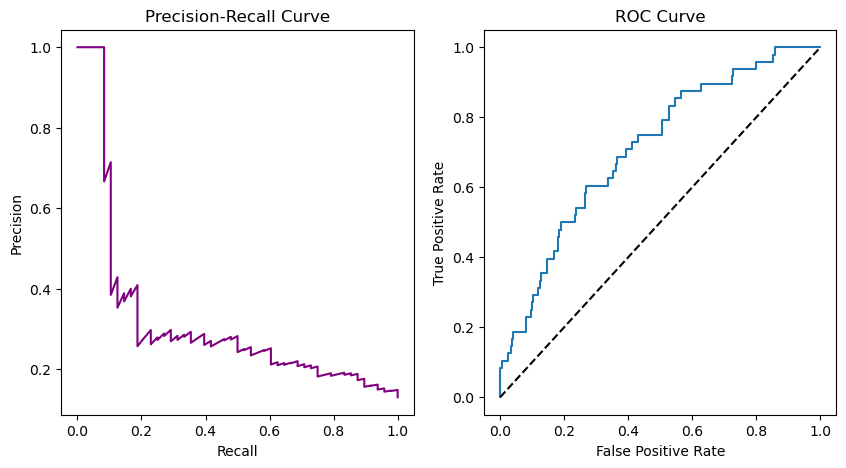

In [432]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(recall, precision, color='purple')
ax[0].set_title('Precision-Recall Curve')
ax[0].set_ylabel('Precision')
ax[0].set_xlabel('Recall')

ax[1].plot(fpr, tpr)
ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')

XGBoost: Использует деревья с жадной структурой, где каждое разделение основано на функции потерь и регуляризации. Он также может автоматически обрабатывать пропущенные значения и решать, в какое поддерево их направлять.

CatBoost: Использует "симметричные" деревья, которые строятся таким образом, чтобы каждый признак имел равный шанс быть использованным в каждом разделении

Вывод:
- Получилось, что если нам важнее точность, лучше использовать модель catboost, а если recall, то xgboost. В общем и целом, обе модели получились слабыми и смогут правильно спрогнозировать текучесть кадров менее чем в половине случаев. 
- Случайный лес получился сильно хуже, чем любая модель градиентного бустинга

# Кластеризация

In [433]:
from sklearn.preprocessing import StandardScaler

data_sc = StandardScaler().fit_transform(data)

Метод главных компонент, для уменьшения признакового пространства:

Text(0, 0.5, 'Cumulative Explained Variance')

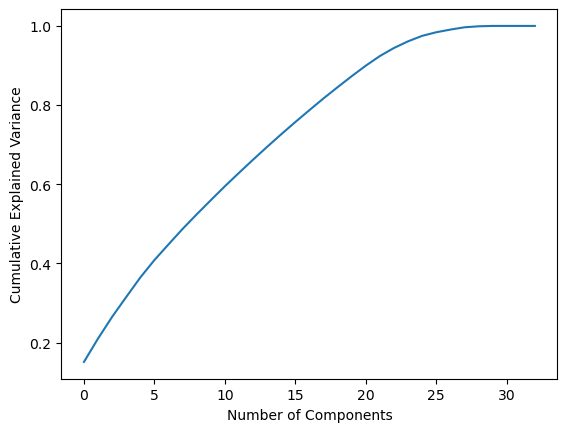

In [434]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_sc)
explained_variance = pca.explained_variance_ratio_

plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [435]:
optimal_components = 0
for i, var in enumerate(np.cumsum(explained_variance)):
    if var > 0.95:
        optimal_components = i
        break
print(f' Минимальное число компонент, описывающее 95% дисперсии: {optimal_components}')

 Минимальное число компонент, описывающее 95% дисперсии: 23


In [436]:
pca = PCA(n_components=optimal_components)
data_pca = pca.fit_transform(data_sc)

Выберу оптимальное число кластеров

Text(0, 0.5, 'inertia')

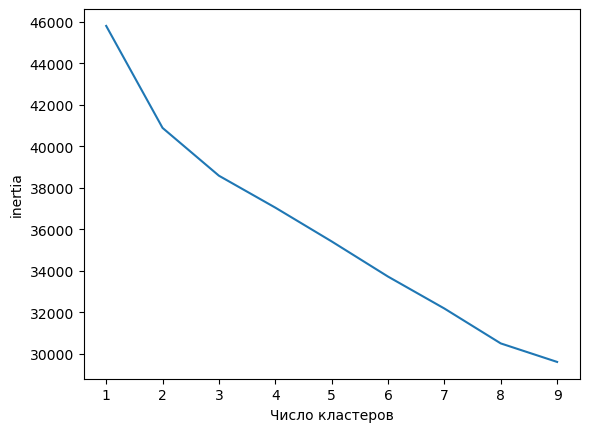

In [437]:
from sklearn.cluster import KMeans

inertias = []
for i in range(1, 10):

    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_pca)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 10), inertias)
plt.xlabel('Число кластеров')
plt.ylabel('inertia')

Сложно определить оптимальное число кластеров, поэтому возьму 2

In [438]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_pca)
labels = pd.Series(kmeans.labels_)
labels.value_counts()

1    1199
0     271
dtype: int64

Видим, что в одном кластере наблюдений в 2 раза больше, чем во втором

# Проведу классификацию по класстерам

In [439]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(pd.DataFrame(data_pca), labels)

label_pred = lr.predict(data_pca)

In [440]:
from sklearn.metrics import accuracy_score
accuracy_score(label_pred, labels)

0.9979591836734694

Модель почти идеально находит кластеры

In [441]:
pd.Series(lr.coef_.ravel()).\
    sort_values(ascending=False, key=lambda x: np.abs(x))[:5]

0    -5.236845
3    -0.719128
14   -0.638110
5    -0.594441
9    -0.578187
dtype: float64

Коэффициенты для каждой компоненты. Видно, что нулевая компонента внесла самый большой вклад в кластеризацию

In [442]:
pd.DataFrame(
    pca.components_, 
    index=pca.get_feature_names_out(), 
    columns=data.columns
).loc['pca0'].sort_values(ascending=False, key=lambda x: np.abs(x))[:5]

AnnualBonus          0.403077
TotalWorkingYears    0.390463
MonthlyIncome        0.384645
YearsAtCompany       0.367697
YearsInCurrentRole   0.296819
Name: pca0, dtype: float64

Это 5 самых влиятельных на эту компоненту признаков. По логике, больше всего влияющих и на кластеризацию